# **PREDICCIÓN DE TURISMO AEREO EN LAS ISLAS BALEARES**


# Índice


---

1.   Objetivo y proposito.
2.   Extracción de los datos.
3.   Limpieza y preprocesamiento de los datos.
4.  Definir metrica y separacion de conjuntos de train y test.
5.   Entrenamiento y seleccion del modelo.
6.   Deploy: gradio + docker

# 1. Objetivo y proposito


---

El **objetivo** del proyecto es **desarrollar un modelo predictivo** que permita **anticipar el turismo aereo** en las Islas Baleares.


#2. Extracción de los datos.


---

Los datos han sido obtenidos de la Agencia de Estrategia Turística de las Islas Baleares, Consejería de Modelo Económico, Turismo y Trabajo. Gobierno de las Islas Baleares.

A su vez los datos son recopilados de AENA, para los datos de pasajeros por vía aérea. Los datos de la operación hub proceden del Departamento de Planificación y Gestión de Operaciones del aeropuerto de Palma.

[Link a CAIB](
https://www.caib.es/sites/estadistiquesdelturisme/es/anuarios_de_turismo-22816/)

Definición más concreta de la obtención:

Turistas por **via aerea** de **tipo comercial** (los puntos pueden variar según el año): 1.1.2 (Baleares), 1.1.5 (Mallorca), 1.1.8 (Menorca), 1.1.8 (Menorca), 1.1.11 (Ibiza).

He recopilado la cantidad de cantidad de turistas por isla y por mes desde 2010 hasta 2023. He creado un CSV y lo he subido a GIT.

In [80]:
import pandas as pd

data = pd.read_csv("https://raw.githubusercontent.com/Esteban0007/Machine_Learning/refs/heads/main/Turismo_aereo_Baleares/cantidad_turistas_baleares.CSV")

In [81]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Año                 540 non-null    int64 
 1   Mes                 540 non-null    object
 2   Isla                540 non-null    object
 3   Número de Turistas  540 non-null    object
dtypes: int64(1), object(3)
memory usage: 17.0+ KB


In [82]:
data.head()

,Año,Mes,Isla,Número de Turistas
0,2023,enero,Mallorca,425049
1,2023,febrero,Mallorca,457444
2,2023,marzo,Mallorca,716450
3,2023,abril,Mallorca,1364111
4,2023,mayo,Mallorca,1620943


# 3. Limpieza y preprocesamiento de los datos.


---

Uso dq_report para hacer un análisis de los datos y ver posibles aspectos a mejorar.

In [83]:
!pip install pandas-dq

In [84]:
from pandas_dq import dq_report
dqr = dq_report(data, target="Número de Turistas", html=False, csv_engine="pandas", verbose=1)

    All variables classified into correct types.


<ipython-input-84-d8deff8a4815>:2: UserWarning:

The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.

<ipython-input-84-d8deff8a4815>:2: UserWarning:

The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.

<ipython-input-84-d8deff8a4815>:2: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



,Data Type,Missing Values%,Unique Values%,Minimum Value,Maximum Value,DQ Issue
Año,int64,0.000000,2,2009.000000,2023.000000,Possible date-time colum: transform before modeling step.
Mes,object,0.000000,2,,,No issue
Isla,object,0.000000,0,,,No issue
Número de Turistas,object,0.000000,97,,,Target column. Appears to have Imbalanced classes. Try balancing classes.


La columna años tiene un error ya que esta como objeto. Voy a arreglar eso y transformarla a int.

In [85]:
# Reemplaza las comas y puntos, luego convierte a entero
data['Número de Turistas'] = data['Número de Turistas'].str.replace(',', '').str.replace('.', '').astype(int)

Transformare las columnas **mes** y **año** por un conjunto de estas llamada **tiempo**.

In [86]:
month_map = {
    'enero': 1, 'febrero': 2, 'marzo': 3, 'abril': 4,
    'mayo': 5, 'junio': 6, 'julio': 7, 'agosto': 8,
    'septiembre': 9, 'octubre': 10, 'noviembre': 11, 'diciembre': 12
}

data = data.assign(Mes=data['Mes'].map(month_map))[['Año', 'Mes', 'Isla', 'Número de Turistas']]




In [87]:
data['Tiempo'] = pd.to_datetime(data['Año'].astype(str) + '-' + data['Mes'].astype(str) + '-01')
data = data.drop(['Año', 'Mes'], axis=1)

Parece que los datos estan mejor. Ahora voy a realizar unas gráficas para entender mejor las llegadas de turismo aereo.

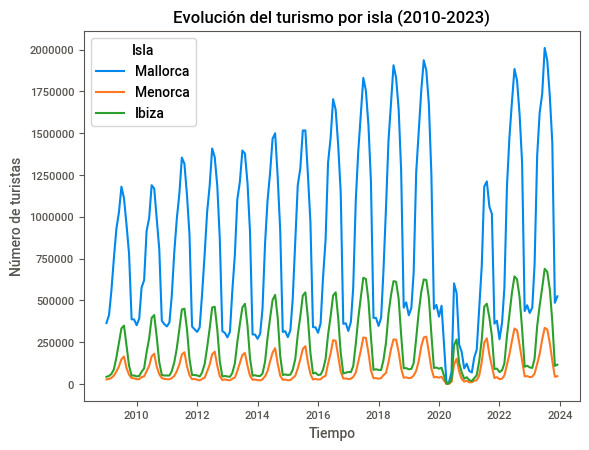

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

# Agrupar los datos por isla y Tiempo, sumando el número de turistas
turismo_por_isla = data.groupby(['Isla', 'Tiempo'])['Número de Turistas'].sum().reset_index()

# Gráfico de líneas
sns.lineplot(x='Tiempo', y='Número de Turistas', hue='Isla', data=data)
plt.title('Evolución del turismo por isla (2010-2023)')
plt.xlabel('Tiempo')
plt.ylabel('Número de turistas')
plt.show()


Podemos ver que hay una anomalía en los datos devido al COVID. Vamos a observarla mejor.

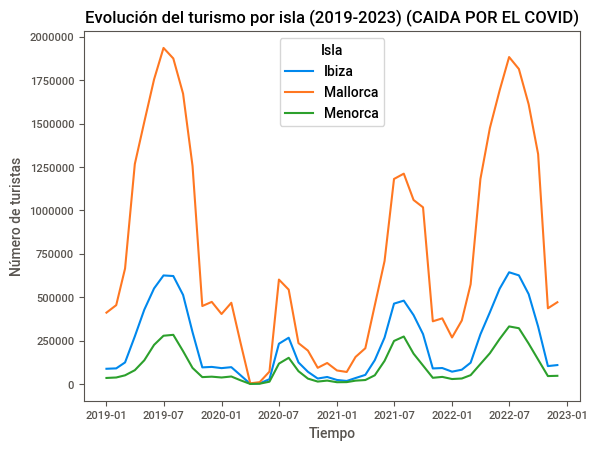

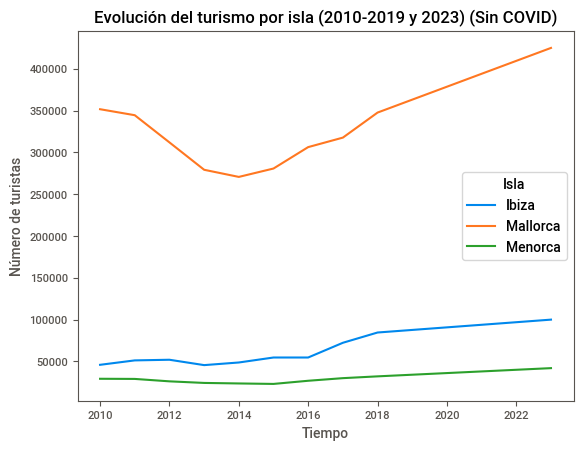

In [89]:
# Filtrar los datos para el rango de años
turismo_por_isla_2010_2022 = turismo_por_isla[turismo_por_isla['Tiempo'].between(pd.to_datetime('2019-01-01'), pd.to_datetime('2022-12-31'))]
turismo_por_isla_sin_covid = turismo_por_isla[turismo_por_isla['Tiempo'].isin(
    pd.to_datetime(list(range(2010, 2019)) + [2023], format='%Y')
)]

# Gráfico de líneas
sns.lineplot(x='Tiempo', y='Número de Turistas', hue='Isla', data=turismo_por_isla_2010_2022)
plt.title('Evolución del turismo por isla (2019-2023) (CAIDA POR EL COVID)')
plt.xlabel('Tiempo')
plt.ylabel('Número de turistas')
plt.show()

# Gráfico de líneas
sns.lineplot(x='Tiempo', y='Número de Turistas', hue='Isla', data=turismo_por_isla_sin_covid)
plt.title('Evolución del turismo por isla (2010-2019 y 2023) (Sin COVID)')
plt.xlabel('Tiempo')
plt.ylabel('Número de turistas')
plt.show()


Se ve una descendencia notable que se recupera en el 2023. En la segunda gráfica se han quitado esos datos y se ve una tendencia más clara. Voy a eliminar la época del COVID ya que distorsiona la realidad.

In [90]:
data = data[(data['Tiempo'] < '2020-01-01') | (data['Tiempo'] >= '2023-01-01')]

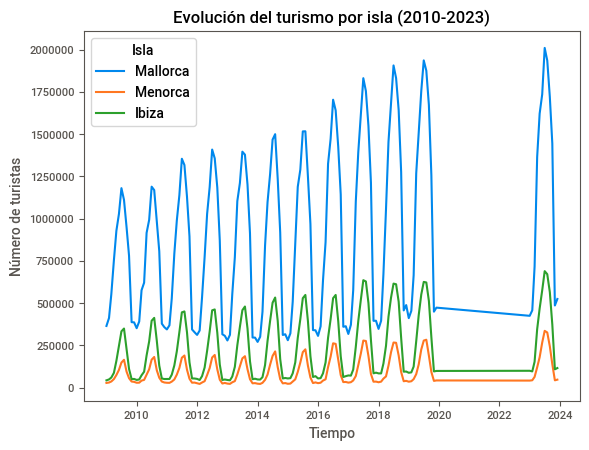

In [91]:
# Gráfico de líneas
sns.lineplot(x='Tiempo', y='Número de Turistas', hue='Isla', data=data)
plt.title('Evolución del turismo por isla (2010-2023)')
plt.xlabel('Tiempo')
plt.ylabel('Número de turistas')
plt.show()

rq_report menciona ( Possible date-time colum: transform before modeling step). Voy a arreglarlo.

In [92]:
data['Tiempo'] = pd.to_numeric(pd.to_datetime(data['Tiempo']))

Vuelvo a usar dq_report para ver el reporte de nuevo.

In [93]:
dqr = dq_report(data, target="Número de Turistas", html=False, csv_engine="pandas", verbose=1)

    All variables classified into correct types.


<ipython-input-93-e67dacfc6e76>:1: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



,Data Type,Missing Values%,Unique Values%,Minimum Value,Maximum Value,DQ Issue
Isla,object,0.000000,0,,,No issue
Número de Turistas,int64,0.000000,97,22135.000000,2009570.000000,Target column
Tiempo,int64,0.000000,33,1230768000000000000.000000,1701388800000000000.000000,No issue


In [94]:
data.head()

,Isla,Número de Turistas,Tiempo
0,Mallorca,425049,1672531200000000000
1,Mallorca,457444,1675209600000000000
2,Mallorca,716450,1677628800000000000
3,Mallorca,1364111,1680307200000000000
4,Mallorca,1620943,1682899200000000000


# 4. Definir metrica y separacion de conjuntos de train y test.


---

## Metrica

La metrica es Error Medio Absoluto (MAE): Mide el promedio de los errores absolutos entre las predicciones y los valores reales. Es útil para interpretar directamente cuánto se desvía en promedio el modelo de los valores reales, en las mismas unidades que los datos originales.

## Train y test

Voy a separar los datos en train y test.

**Conjunto de entrenamiento**: Datos de 2010 a 2018.

**Conjunto de prueba**: Datos de 2019 y 2023.

In [95]:
# Convert 'Tiempo' column to datetime
data['Tiempo'] = pd.to_datetime(data['Tiempo'])

# Crear una máscara para los datos de prueba (2019 y 2023)
test_mask = data['Tiempo'].dt.year.isin([2019, 2023])

# Volvemos a dejarlo bien
data['Tiempo'] = pd.to_numeric(pd.to_datetime(data['Tiempo']))

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train = data[~test_mask].drop('Número de Turistas', axis=1)
y_train = data[~test_mask]['Número de Turistas']
X_test = data[test_mask].drop('Número de Turistas', axis=1)
y_test = data[test_mask]['Número de Turistas']

In [96]:
import pandas as pd

# Define df_train by combining X_train and y_train
df_train_total = pd.concat([X_train, y_train], axis=1)

# Define tst by combining X_test and y_test
df_test = pd.concat([X_test, y_test], axis=1)

Voy a analizar con sweetviz train y  test contra train.

In [97]:
!pip install sweetviz -U -q

In [98]:
import sweetviz as sv


In [99]:
df_train = pd.concat([X_train, y_train], axis=1)
my_report = sv.analyze(df_train)
my_report.show_html("reporte_train.html")

                                             |          | [  0%]   00:00 -> (? left)

Report reporte_train.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [100]:
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

In [101]:
my_report = sv.compare([df_train, "Training Data"], [df_test, "Test Data"], target_feat="Número de Turistas")
my_report.show_html("reporte_train_vs_test.html")

                                             |          | [  0%]   00:00 -> (? left)

Report reporte_train_vs_test.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


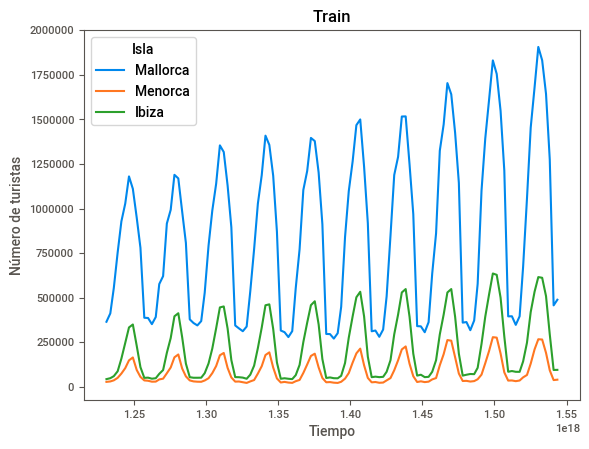

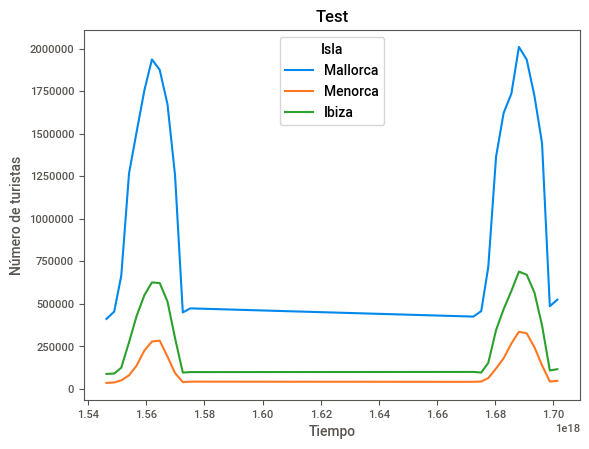

In [102]:
# Gráfico de líneas
sns.lineplot(x='Tiempo', y='Número de Turistas', hue='Isla', data=df_train)
plt.title('Train')
plt.xlabel('Tiempo')
plt.ylabel('Número de turistas')
plt.show()

# Gráfico de líneas
sns.lineplot(x='Tiempo', y='Número de Turistas', hue='Isla', data=df_test)
plt.title('Test')
plt.xlabel('Tiempo')
plt.ylabel('Número de turistas')
plt.show()

Ya tengo test y train. Pero el test no lo voy a tocar hasta el final asi que voy a dividir train en train y validation.

In [103]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Finalmente necesitaré esta división.

In [104]:
import pandas as pd

# Define una función para separar los datos por isla
def separar_por_isla(data, isla):
    isla_data = data[data['Isla'] == isla]
    # Convierte la columna 'Tiempo' a datetime si no lo es
    isla_data['Tiempo'] = pd.to_datetime(isla_data['Tiempo'])
    # Crea una máscara para los datos de prueba (2019 y 2023)
    test_mask = isla_data['Tiempo'].dt.year.isin([2019, 2023])

    # Dividir los datos en conjuntos de entrenamiento y prueba
    train_data = isla_data[~test_mask]
    test_data = isla_data[test_mask]

    return train_data, test_data


# Separa los datos para cada isla
mallorca_train, mallorca_test = separar_por_isla(data, 'Mallorca')
menorca_train, menorca_test = separar_por_isla(data, 'Menorca')
ibiza_train, ibiza_test = separar_por_isla(data, 'Ibiza')
formentera_train, formentera_test = separar_por_isla(data, 'Formentera')

<ipython-input-104-4be31539faf6>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-104-4be31539faf6>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-104-4be31539faf6>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# 5. Entrenamiento, test, analisis, Interpretacion y seleccion del modelo.


---

## Baseline con Dummy

In [105]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import r2_score

# Crear el modelo Dummy
dummy_regr = DummyRegressor(strategy="mean")

# Entrenar el modelo
dummy_regr.fit(X_train, y_train)

# Realizar predicciones en el conjunto de validación
y_pred = dummy_regr.predict(X_val)

# Calcular el R-squared
r2 = r2_score(y_val, y_pred)

# Imprimir el R-squared
print(f"R-squared del modelo Dummy: {r2}")

R-squared del modelo Dummy: -0.04018074003820016


In [106]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_val, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 358054.94965277775


## Modelo de regresión lineal

In [107]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


# Create and train the linear regression model using the numerical 'Tiempo_num' column
regr = LinearRegression()
regr.fit(X_train[['Tiempo']], y_train)

# Make predictions using the numerical 'Tiempo_num' column in X_val
y_pred = regr.predict(X_val[['Tiempo']])

# Calculate R-squared
r2 = r2_score(y_val, y_pred)

# Print R-squared
print(f"R-squared del modelo de regresión lineal: {r2}")

R-squared del modelo de regresión lineal: 0.006870405753455877


In [108]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_val, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 355147.31589544204


El modelo de regresión lineal me da un error más bajo que el dummy.

## Predicción con FLAM AUTOML

In [109]:
mallorca_train.head()

,Isla,Número de Turistas,Tiempo
180,Mallorca,347683,2018-01-01
181,Mallorca,395794,2018-02-01
182,Mallorca,673316,2018-03-01
183,Mallorca,1055735,2018-04-01
184,Mallorca,1453489,2018-05-01


In [110]:
!pip install flaml[automl]

In [111]:
from flaml import AutoML
import pandas as pd

# Separar las características y el objetivo
X_train = mallorca_train[['Tiempo']]
y_train = mallorca_train['Número de Turistas']
X_test = mallorca_test[['Tiempo']]
y_test = mallorca_test['Número de Turistas']

FLAML realiza automaticamente validación cruzada con los datos de train asi que basta con darle los datos de train

In [112]:
# Inicializar AutoML
automl = AutoML()

# Configurar los parámetros (opcional)
settings = {
    "time_budget": 60,  # Tiempo límite en segundos
    "metric": 'mae',  # Métrica de evaluación
    "task": 'regression',  # Tipo de tarea
    "log_file_name": "flaml_automl.log",  # Archivo de registro (opcional)
}

# Entrenar el modelo
automl.fit(X_train=X_train, y_train=y_train, **settings)

[flaml.automl.logger: 10-30 23:20:29] {1728} INFO - task = regression
[flaml.automl.logger: 10-30 23:20:29] {1739} INFO - Evaluation method: cv
[flaml.automl.logger: 10-30 23:20:29] {1838} INFO - Minimizing error metric: mae
[flaml.automl.logger: 10-30 23:20:29] {1955} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd']
[flaml.automl.logger: 10-30 23:20:29] {2258} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 10-30 23:20:30] {2393} INFO - Estimated sufficient time budget=5985s. Estimated necessary time budget=43s.
[flaml.automl.logger: 10-30 23:20:30] {2442} INFO -  at 0.6s,	estimator lgbm's best error=318321.6295,	best estimator lgbm's best error=318321.6295
[flaml.automl.logger: 10-30 23:20:30] {2258} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 10-30 23:20:30] {2442} INFO -  at 0.9s,	estimator lgbm's best error=318321.6295,	best estimator lgbm's best error=318321.6295
[flaml.automl.logger: 10-3

INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune


[flaml.automl.logger: 10-30 23:20:32] {2442} INFO -  at 2.9s,	estimator sgd's best error=867028.8183,	best estimator lgbm's best error=58411.7301
[flaml.automl.logger: 10-30 23:20:32] {2258} INFO - iteration 14, current learner lgbm
[flaml.automl.logger: 10-30 23:20:33] {2442} INFO -  at 3.9s,	estimator lgbm's best error=58411.7301,	best estimator lgbm's best error=58411.7301
[flaml.automl.logger: 10-30 23:20:33] {2258} INFO - iteration 15, current learner sgd
[flaml.automl.logger: 10-30 23:20:33] {2442} INFO -  at 4.0s,	estimator sgd's best error=867028.8183,	best estimator lgbm's best error=58411.7301
[flaml.automl.logger: 10-30 23:20:33] {2258} INFO - iteration 16, current learner lgbm
[flaml.automl.logger: 10-30 23:20:34] {2442} INFO -  at 4.2s,	estimator lgbm's best error=58411.7301,	best estimator lgbm's best error=58411.7301
[flaml.automl.logger: 10-30 23:20:34] {2258} INFO - iteration 17, current learner sgd
[flaml.automl.logger: 10-30 23:20:34] {2442} INFO -  at 4.3s,	estimato

In [113]:
# Realizar predicciones en el conjunto de prueba
predictions = automl.predict(X_test)

# Crear un DataFrame con las predicciones y los valores reales
results = pd.DataFrame({'Tiempo': mallorca_test['Tiempo'], 'Real': y_test, 'Predicciones': predictions})

# Convertir 'Tiempo' a datetime para la visualización
results['Tiempo'] = pd.to_datetime(results['Tiempo'])

# Visualizar con Plotly
import plotly.express as px

fig = px.line(results, x='Tiempo', y=['Real', 'Predicciones'], title='Predicciones AutoML con FLAML')
fig.show()

In [114]:
# prompt: que r2 me da el modelo con Flam

# Calcular el R-squared para el modelo FLAML
r2_flaml = r2_score(y_test, predictions)

# Imprimir el R-squared
print(f"R-squared del modelo FLAML: {r2_flaml}")

R-squared del modelo FLAML: 0.9665667195183011


In [115]:
mae_flaml = mean_absolute_error(y_test, predictions)

print(f"Mean Absolute Error (MAE) del modelo FLAML: {mae_flaml}")

Mean Absolute Error (MAE) del modelo FLAML: 88542.68930534406


Funciona muy bien !! voy a probar con años desconocidos...

In [116]:
# --- Future predictions ---
# Generar fechas futuras
future_dates = pd.DataFrame(pd.date_range(start='2018-01-01', end='2050-12-31', freq='MS'), columns=['Tiempo'])

# Realizar predicciones en las fechas futuras
future_predictions = automl.predict(future_dates[['Tiempo']])

# Crear un DataFrame con las predicciones y los valores reales
future_results = pd.DataFrame({'Tiempo': future_dates['Tiempo'], 'Predicciones': future_predictions})
future_results['Tiempo'] = pd.to_datetime(future_results['Tiempo'])

# --- Combine data and future predictions ---
# Concatenate historical and future data
combined_results = pd.concat([
    mallorca_train[['Tiempo', 'Número de Turistas']].rename(columns={'Número de Turistas': 'Real'}),
    future_results.rename(columns={'Predicciones': 'Real'})
])

# --- Visualization ---
# Visualizar con Plotly
fig = px.line(combined_results, x='Tiempo', y=['Real'], title='Predicciones AutoML con FLAML (Futuro)', color_discrete_sequence=['blue'])  # Set color for historical data
fig.add_trace(px.line(future_results, x='Tiempo', y=['Predicciones'], color_discrete_sequence=['red']).data[0])  # Set color for future predictions
fig.show()

No pilla la tendencia ascendente. Voy a probar con Prophet


## Prophet

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9b218lxu/7o2enyc6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9b218lxu/6ynlrog1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32593', 'data', 'file=/tmp/tmp9b218lxu/7o2enyc6.json', 'init=/tmp/tmp9b218lxu/6ynlrog1.json', 'output', 'file=/tmp/tmp9b218lxu/prophet_model9asdfxpx/prophet_model-20241030232131.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:21:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:21:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


El MAE es: 79372.28238468735


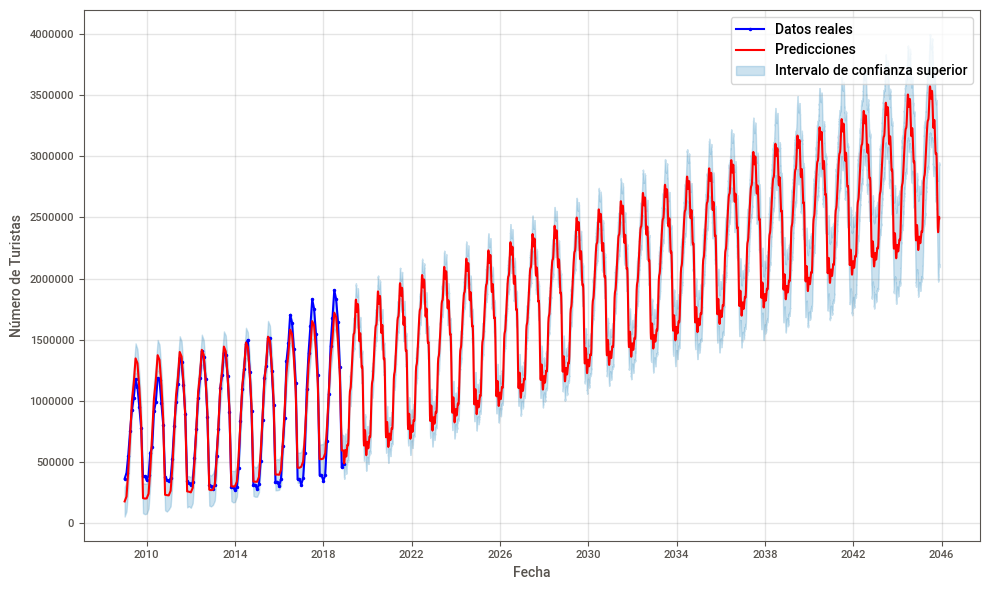

In [117]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Crea un DataFrame con las columnas 'ds' (fecha) e 'y' (valor)
df = mallorca_train[['Tiempo', 'Número de Turistas']].rename(columns={'Tiempo': 'ds', 'Número de Turistas': 'y'})

# Crea un modelo Prophet
model = Prophet()

# Ajusta el modelo a los datos
model.fit(df)

# Crea un DataFrame con las fechas futuras, comenzando después del último dato real
future = model.make_future_dataframe(periods=365 * 27, freq='D')  # 27 años en el futuro, frecuencia diaria

# Remove filtering for future dates to allow overlap for MAE calculation
# future = future[future['ds'] > df['ds'].max()]  # Filtrar fechas futuras

forecast = model.predict(future)

# Filtrar las predicciones, including historical dates for MAE calculation
predictions = forecast[['ds', 'yhat']].merge(df, on='ds', how='inner')

# MAE
mae = mean_absolute_error(predictions['y'], predictions['yhat'])
print(f"El MAE es: {mae}")

# Realiza predicciones para todas las fechas (históricas y futuras)
forecast = model.predict(future)

# Visualiza las predicciones con colores distintos y datos reales como línea
fig = model.plot(forecast)

# Obtener el objeto Axes del gráfico
ax = fig.gca()

# Modificar el color de los datos reales
ax.lines[0].set_color('blue')  # Cambia el color a azul
ax.lines[0].set_linestyle('-')  # Cambia el estilo de línea a línea continua

# Modificar el color de las predicciones
ax.lines[1].set_color('red')  # Cambia el color a rojo

# Modificar títulos de ejes
plt.xlabel('Fecha')
plt.ylabel('Número de Turistas')

# Agregar leyenda
plt.legend(['Datos reales', 'Predicciones', 'Intervalo de confianza superior', 'Intervalo de confianza inferior'])



plt.show()

Se ve que este modelo si que funciona mejor en datos duturos a cambio de un  poco más de fallo pero permisivo.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9b218lxu/nvx9neip.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9b218lxu/oz1go61w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50781', 'data', 'file=/tmp/tmp9b218lxu/nvx9neip.json', 'init=/tmp/tmp9b218lxu/oz1go61w.json', 'output', 'file=/tmp/tmp9b218lxu/prophet_model6ng0udme/prophet_model-20241030232149.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:21:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:21:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


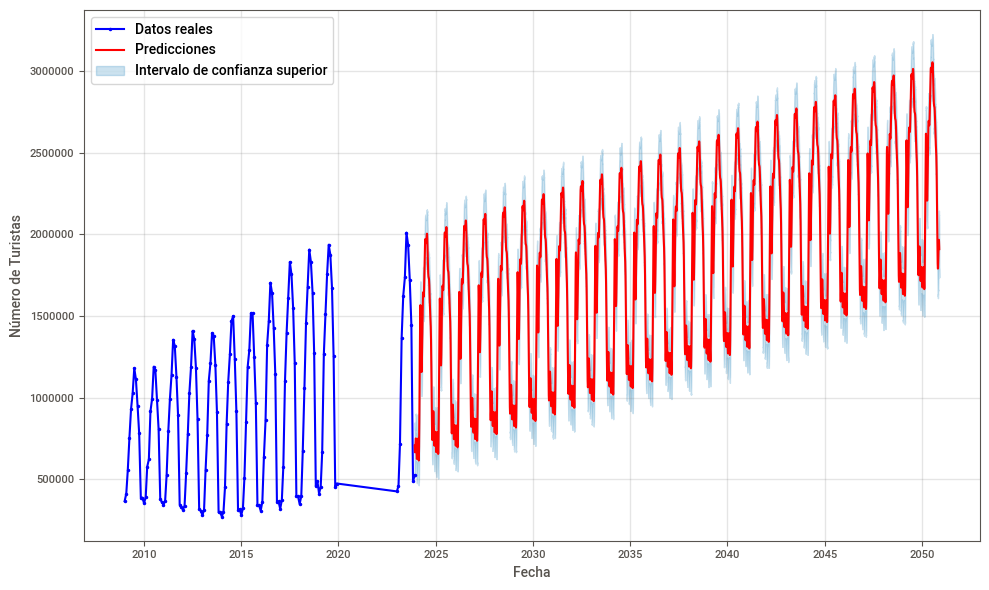

In [118]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

mallorca_total = pd.concat([mallorca_train, mallorca_test])

# Crea un DataFrame con las columnas 'ds' (fecha) e 'y' (valor)
df = mallorca_total[['Tiempo', 'Número de Turistas']].rename(columns={'Tiempo': 'ds', 'Número de Turistas': 'y'})

# Crea un modelo Prophet
model = Prophet()

# Ajusta el modelo a los datos
model.fit(df)

# Crea un DataFrame con las fechas futuras, comenzando después del último dato real
future = model.make_future_dataframe(periods=365 * 27, freq='D')  # 27 años en el futuro, frecuencia diaria
future = future[future['ds'] > df['ds'].max()]  # Filtrar fechas futuras

# Realiza predicciones solo para las fechas futuras
forecast = model.predict(future)

# Visualiza las predicciones con colores distintos y datos reales como línea
fig = model.plot(forecast)

# Obtener el objeto Axes del gráfico
ax = fig.gca()

# Modificar el color de los datos reales
ax.lines[0].set_color('blue')  # Cambia el color a azul
ax.lines[0].set_linestyle('-')  # Cambia el estilo de línea a línea continua

# Modificar el color de las predicciones
ax.lines[1].set_color('red')  # Cambia el color a rojo

# Modificar títulos de ejes
plt.xlabel('Fecha')
plt.ylabel('Número de Turistas')

# Agregar leyenda
plt.legend(['Datos reales', 'Predicciones', 'Intervalo de confianza superior', 'Intervalo de confianza inferior'])

plt.show()

In [119]:
import pickle
# Guardar el modelo Prophet
with open('modelo_prophet_mallorca_total.pkl', 'wb') as archivo:
    pickle.dump(model, archivo)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9b218lxu/rad68edf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9b218lxu/xulgqx75.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93278', 'data', 'file=/tmp/tmp9b218lxu/rad68edf.json', 'init=/tmp/tmp9b218lxu/xulgqx75.json', 'output', 'file=/tmp/tmp9b218lxu/prophet_model0y4jgu81/prophet_model-20241030232155.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:21:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:21:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


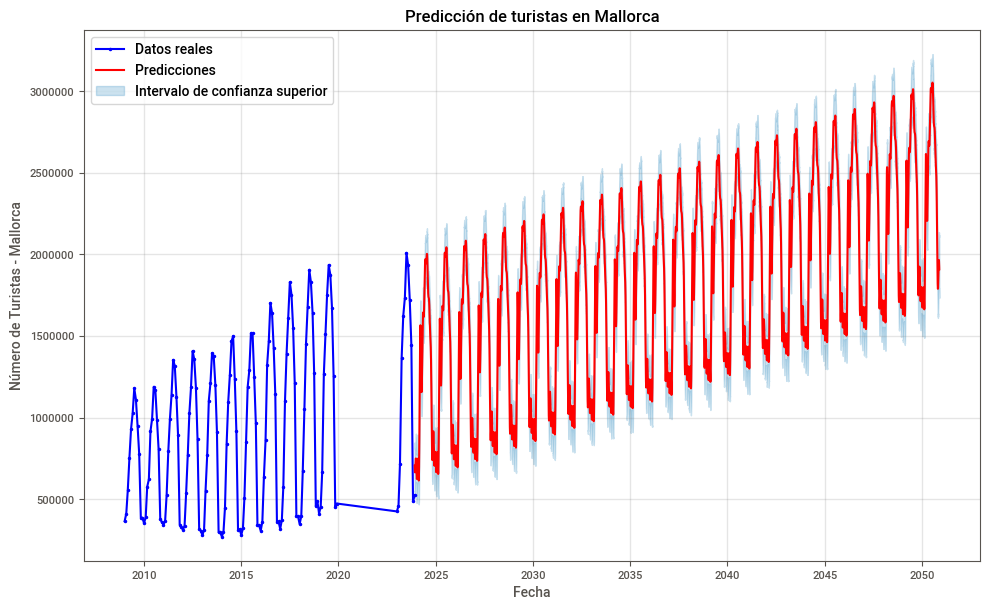

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9b218lxu/7nea8ail.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9b218lxu/qdqo650y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95596', 'data', 'file=/tmp/tmp9b218lxu/7nea8ail.json', 'init=/tmp/tmp9b218lxu/qdqo650y.json', 'output', 'file=/tmp/tmp9b218lxu/prophet_modelqezisz20/prophet_model-20241030232201.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:22:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:22:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


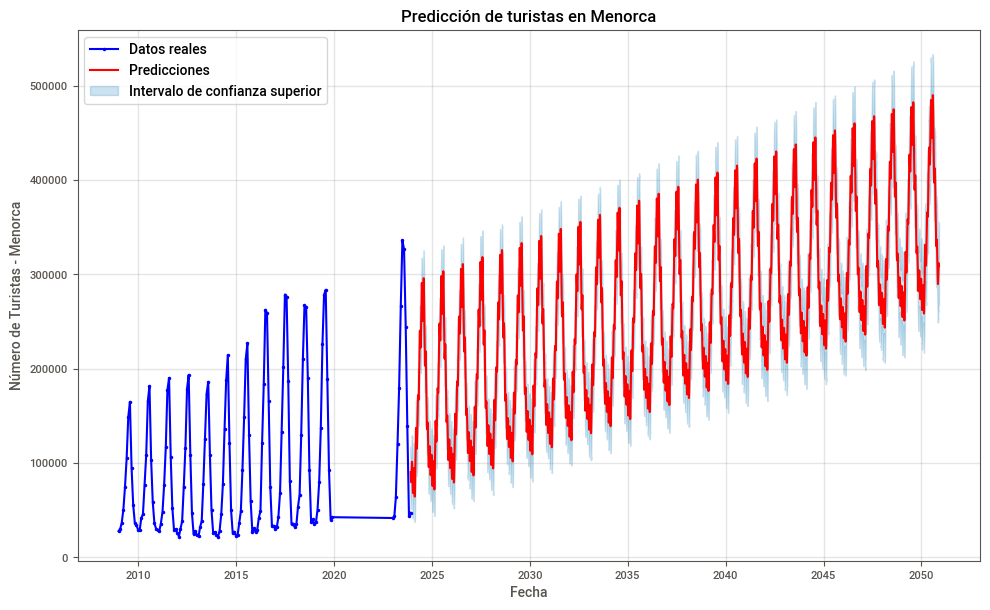

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9b218lxu/o2mr7lzq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9b218lxu/iwplriks.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89256', 'data', 'file=/tmp/tmp9b218lxu/o2mr7lzq.json', 'init=/tmp/tmp9b218lxu/iwplriks.json', 'output', 'file=/tmp/tmp9b218lxu/prophet_model4fw4pcjg/prophet_model-20241030232208.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:22:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:22:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


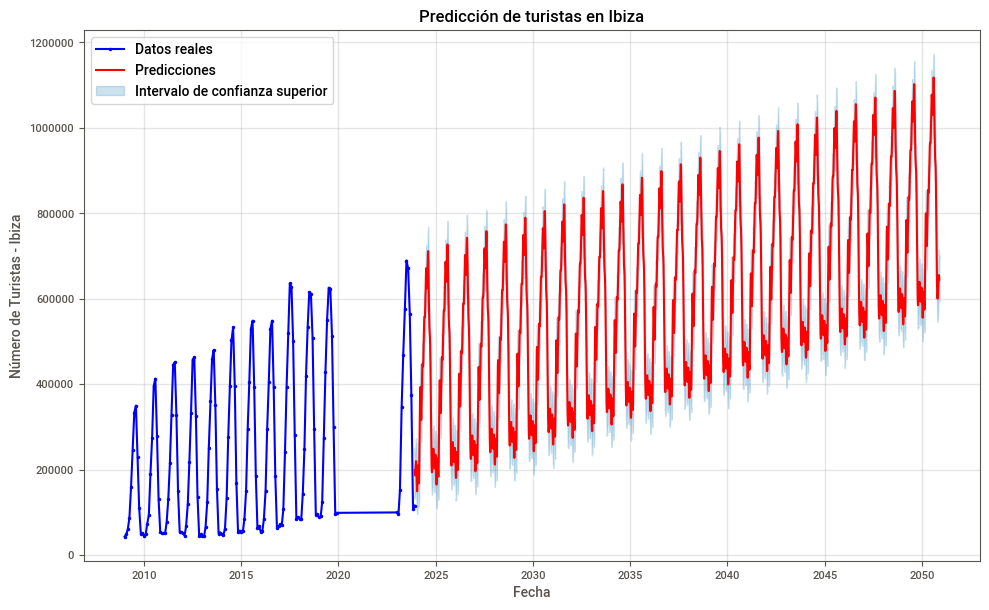

In [120]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import pickle  # Para guardar los modelos entrenados

mallorca_total = pd.concat([mallorca_train, mallorca_test])
menorca_total = pd.concat([menorca_train, menorca_test])
ibiza_total = pd.concat([ibiza_train, ibiza_test])


# Diccionario con los datos de cada isla
islas = {
    'Mallorca': mallorca_total,  # Asumiendo que tienes ya un DataFrame llamado 'mallorca_total'
    'Menorca': menorca_total,    # Reemplaza con tu DataFrame para cada isla
    'Ibiza': ibiza_total,
}

# Bucle para ajustar y guardar el modelo para cada isla
for isla, data in islas.items():
    # Crear el DataFrame con las columnas 'ds' y 'y'
    df = data[['Tiempo', 'Número de Turistas']].rename(columns={'Tiempo': 'ds', 'Número de Turistas': 'y'})

    # Crear y ajustar el modelo Prophet
    model = Prophet()
    model.fit(df)

    # Crear un DataFrame con las fechas futuras, comenzando después del último dato real
    future = model.make_future_dataframe(periods=365 * 27, freq='D')  # 27 años en el futuro, frecuencia diaria
    future = future[future['ds'] > df['ds'].max()]  # Filtrar fechas futuras

    # Realizar predicciones solo para las fechas futuras
    forecast = model.predict(future)

    # Visualizar las predicciones con colores distintos
    fig = model.plot(forecast)
    ax = fig.gca()
    ax.lines[0].set_color('blue')  # Datos reales
    ax.lines[0].set_linestyle('-')
    ax.lines[1].set_color('red')   # Predicciones

    # Títulos de ejes
    plt.xlabel('Fecha')
    plt.ylabel(f'Número de Turistas - {isla}')

    # Agregar leyenda
    plt.legend(['Datos reales', 'Predicciones', 'Intervalo de confianza superior', 'Intervalo de confianza inferior'])

    # Mostrar gráfico
    plt.title(f'Predicción de turistas en {isla}')
    plt.show()

    # Guardar el modelo entrenado para la isla
    with open(f'model_{isla}.pkl', 'wb') as file:
        pickle.dump(model, file)


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9b218lxu/xrb_c_oj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9b218lxu/yxmsgqqf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47412', 'data', 'file=/tmp/tmp9b218lxu/xrb_c_oj.json', 'init=/tmp/tmp9b218lxu/yxmsgqqf.json', 'output', 'file=/tmp/tmp9b218lxu/prophet_modelkq1ter3d/prophet_model-20241030232212.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:22:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:22:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


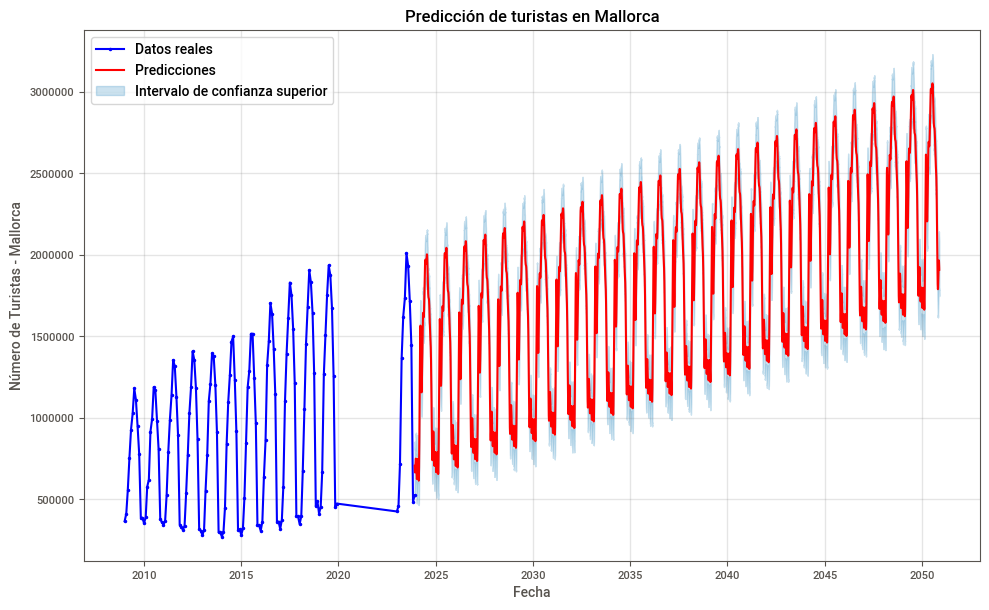

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9b218lxu/t3dl5s4l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9b218lxu/j9j2c1_3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20180', 'data', 'file=/tmp/tmp9b218lxu/t3dl5s4l.json', 'init=/tmp/tmp9b218lxu/j9j2c1_3.json', 'output', 'file=/tmp/tmp9b218lxu/prophet_modelg23ehf_c/prophet_model-20241030232220.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:22:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:22:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


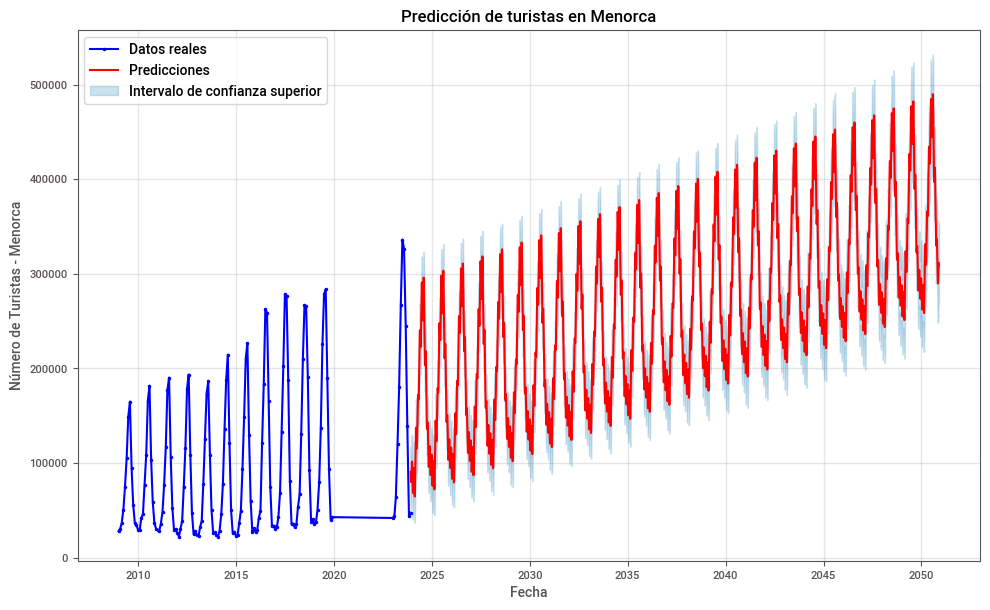

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9b218lxu/4g02hjhs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9b218lxu/60tp1h7c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5191', 'data', 'file=/tmp/tmp9b218lxu/4g02hjhs.json', 'init=/tmp/tmp9b218lxu/60tp1h7c.json', 'output', 'file=/tmp/tmp9b218lxu/prophet_modelysopdyc1/prophet_model-20241030232224.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:22:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:22:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


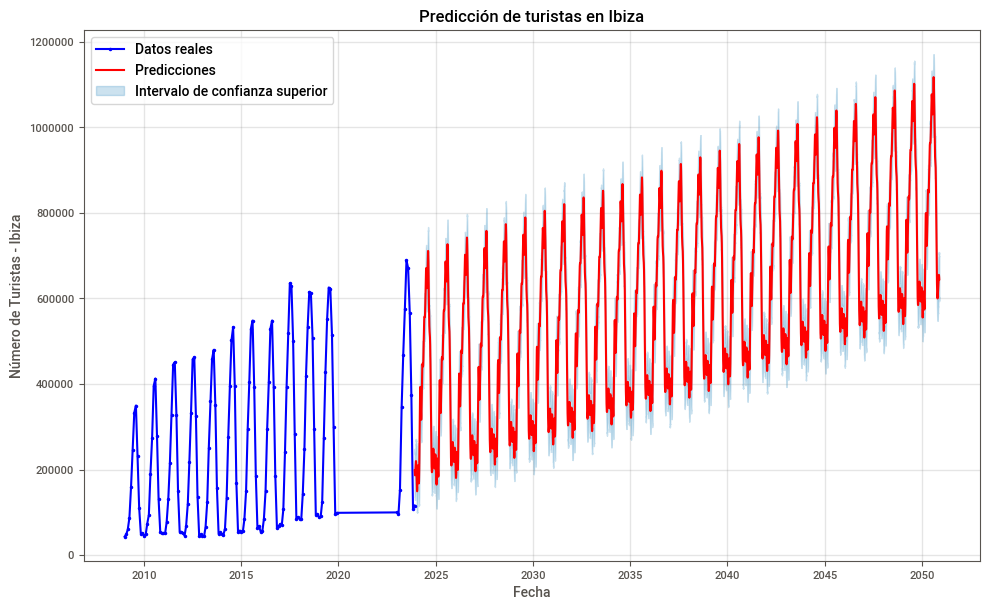

In [121]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import pickle  # Para guardar los modelos entrenados

# Concatenar los datos de entrenamiento y prueba
mallorca_total = pd.concat([mallorca_train, mallorca_test])
menorca_total = pd.concat([menorca_train, menorca_test])
ibiza_total = pd.concat([ibiza_train, ibiza_test])

# Diccionario con los datos de cada isla
islas = {
    'Mallorca': mallorca_total,
    'Menorca': menorca_total,
    'Ibiza': ibiza_total,
}

# Bucle para ajustar y guardar el modelo para cada isla
for isla, data in islas.items():
    # Crear el DataFrame con las columnas 'ds' y 'y'
    df = data[['Tiempo', 'Número de Turistas']].rename(columns={'Tiempo': 'ds', 'Número de Turistas': 'y'})

    # Crear y ajustar el modelo Prophet
    model = Prophet()
    model.fit(df)

    # Crear un DataFrame con las fechas futuras
    future = model.make_future_dataframe(periods=365 * 27, freq='D')  # 27 años en el futuro
    future = future[future['ds'] > df['ds'].max()]  # Filtrar fechas futuras

    # Realizar predicciones solo para las fechas futuras
    forecast = model.predict(future)

    # Visualizar las predicciones con colores distintos
    fig = model.plot(forecast)
    ax = fig.gca()
    ax.lines[0].set_color('blue')  # Datos reales
    ax.lines[0].set_linestyle('-')
    ax.lines[1].set_color('red')   # Predicciones

    # Títulos de ejes
    plt.xlabel('Fecha')
    plt.ylabel(f'Número de Turistas - {isla}')

    # Agregar leyenda
    plt.legend(['Datos reales', 'Predicciones', 'Intervalo de confianza superior', 'Intervalo de confianza inferior'])

    # Establecer el título del gráfico
    plt.title(f'Predicción de turistas en {isla}')

    # Guardar el gráfico como imagen PNG
    plt.savefig(f'grafico_prediccion_{isla}.png')  # Guardar el gráfico con un nombre único
    plt.show()  # Mostrar el gráfico
    plt.close()  # Cerrar la figura para evitar mostrarla automáticamente en futuras iteraciones

    # Guardar el modelo entrenado para la isla
    with open(f'model_{isla}.pkl', 'wb') as file:
        pickle.dump(model, file)


# 6. Gradio

In [122]:
!pip install gradio -q -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.8/319.8 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.7/94.7 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.5/447.5 kB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 93.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 9.4 MB/s eta 0:00:00


In [123]:
import gradio as gr
import pandas as pd
from prophet import Prophet
import pickle
import matplotlib.pyplot as plt
from datetime import datetime

# Cargar los modelos entrenados para cada isla
modelos = {
    'Mallorca': pickle.load(open('model_Mallorca.pkl', 'rb')),
    'Menorca': pickle.load(open('model_Menorca.pkl', 'rb')),
    'Ibiza': pickle.load(open('model_Ibiza.pkl', 'rb')),
}

# Mapeo de los nombres de los meses
meses = {
    "Enero": 1, "Febrero": 2, "Marzo": 3, "Abril": 4,
    "Mayo": 5, "Junio": 6, "Julio": 7, "Agosto": 8,
    "Septiembre": 9, "Octubre": 10, "Noviembre": 11, "Diciembre": 12
}

# Función para realizar la predicción y generar el gráfico
def predecir_turistas(isla, año, mes_nombre):
    # Seleccionar el modelo de la isla elegida
    modelo = modelos[isla]
    mes = meses[mes_nombre]  # Convertir el nombre del mes a número

    # Crear una fecha con el año y mes ingresado
    fecha = pd.to_datetime(f"{año}-{mes}-01")

    # Generar predicciones extendidas en el tiempo
    future_anual = modelo.make_future_dataframe(periods=365 * (año - datetime.now().year + 1), freq='D')

    # Realizar predicciones sobre el periodo extendido
    forecast_anual = modelo.predict(future_anual)

    # Filtrar la predicción específica del mes y año seleccionados
    prediccion_mes = forecast_anual[(forecast_anual['ds'].dt.year == año) & (forecast_anual['ds'].dt.month == mes)]
    if prediccion_mes.empty:
        return "No hay predicción disponible para esta fecha.", None

    prediccion = prediccion_mes['yhat'].values[0]

    # Filtrar las predicciones del año completo para el gráfico
    forecast_anio = forecast_anual[forecast_anual['ds'].dt.year == año]

    # Generar el gráfico de predicciones para el año completo
    plt.figure(figsize=(10, 6))
    plt.plot(forecast_anio['ds'], forecast_anio['yhat'], color='red', label="Predicciones")
    plt.fill_between(forecast_anio['ds'], forecast_anio['yhat_lower'], forecast_anio['yhat_upper'], color='pink', alpha=0.3, label="Intervalo de confianza")
    plt.xlabel("Fecha")
    plt.ylabel("Número de Turistas")
    plt.title(f"Predicción de turistas en {isla} para {año}")
    plt.legend()
    plt.grid(True)

    # Guardar el gráfico
    plt.savefig("prediccion_anual.png")
    plt.close()

    # Formatear la salida
    prediccion_texto = f"Predicción para {isla} en {mes_nombre} {año}: {int(prediccion):,} turistas"
    return prediccion_texto, "prediccion_anual.png"

# Crear la interfaz Gradio
interfaz = gr.Interface(
    fn=predecir_turistas,
    inputs=[
        gr.Dropdown(choices=['Mallorca', 'Menorca', 'Ibiza'], label="Isla"),
        gr.Number(label="Año", value=2024, precision=0),
        gr.Dropdown(choices=list(meses.keys()), label="Mes")
    ],
    outputs=[
        gr.Textbox(label="Predicción del Número de Turistas"),
        gr.Image(label="Gráfico de Predicción Anual")
    ],
    title="Predicción de Turistas en las Islas Baleares",
    description="Seleccione una isla, un año y un mes para obtener la predicción del número de turistas y el gráfico anual."
)

# Lanzar la interfaz
interfaz.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://9896a94927fd77092f.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Voy a mejorarlo.

In [124]:
import gradio as gr
import pandas as pd
from prophet import Prophet
import pickle
import matplotlib.pyplot as plt
from datetime import datetime

# Cargar los modelos entrenados para cada isla
modelos = {
    'Mallorca': pickle.load(open('model_Mallorca.pkl', 'rb')),
    'Menorca': pickle.load(open('model_Menorca.pkl', 'rb')),
    'Ibiza': pickle.load(open('model_Ibiza.pkl', 'rb')),
}

# Mapeo de los nombres de los meses
meses = {
    "Enero": 1, "Febrero": 2, "Marzo": 3, "Abril": 4,
    "Mayo": 5, "Junio": 6, "Julio": 7, "Agosto": 8,
    "Septiembre": 9, "Octubre": 10, "Noviembre": 11, "Diciembre": 12
}

# Función para realizar la predicción y generar los gráficos
def predecir_turistas(isla, año, mes_nombre):
    # Seleccionar el modelo de la isla elegida
    modelo = modelos[isla]
    mes = meses[mes_nombre]  # Convertir el nombre del mes a número

    # Crear una fecha con el año y mes ingresado
    fecha = pd.to_datetime(f"{año}-{mes}-01")

    # Generar predicciones extendidas en el tiempo
    future_anual = modelo.make_future_dataframe(periods=365 * (año - datetime.now().year + 1), freq='D')

    # Realizar predicciones sobre el periodo extendido
    forecast_anual = modelo.predict(future_anual)

    # Filtrar la predicción específica del mes y año seleccionados
    prediccion_mes = forecast_anual[(forecast_anual['ds'].dt.year == año) & (forecast_anual['ds'].dt.month == mes)]
    if prediccion_mes.empty:
        return "No hay predicción disponible para esta fecha.", None, None, None

    prediccion = prediccion_mes['yhat'].values[0]

    # Filtrar las predicciones del año completo para el gráfico
    forecast_anio = forecast_anual[forecast_anual['ds'].dt.year == año]

    # Generar el gráfico de predicciones para el año completo
    plt.figure(figsize=(10, 6))
    plt.plot(forecast_anio['ds'], forecast_anio['yhat'], color='red', label="Predicciones")
    plt.fill_between(forecast_anio['ds'], forecast_anio['yhat_lower'], forecast_anio['yhat_upper'], color='pink', alpha=0.3, label="Intervalo de confianza")
    plt.xlabel("Fecha")
    plt.ylabel("Número de Turistas")
    plt.title(f"Predicción de turistas en {isla} para {año}")
    plt.legend()
    plt.grid(True)

    # Guardar el gráfico anual
    plt.savefig("prediccion_anual.png")
    plt.close()

    # Generar el gráfico por isla
    fig_isla = modelo.plot(forecast_anual)
    ax_isla = fig_isla.gca()
    ax_isla.lines[0].set_color('blue')  # Datos reales
    ax_isla.lines[0].set_linestyle('-')
    ax_isla.lines[1].set_color('red')   # Predicciones
    plt.title(f'Predicción de turistas en {isla}')

    # Guardar el gráfico por isla
    plt.savefig(f'grafico_prediccion_{isla}.png')
    plt.close()

    # Filtrar las predicciones solo para el mes específico
    forecast_mes = forecast_anual[(forecast_anual['ds'].dt.year == año) & (forecast_anual['ds'].dt.month == mes)]

    # Generar el gráfico de predicción solo para el mes
    plt.figure(figsize=(10, 6))
    plt.plot(forecast_mes['ds'], forecast_mes['yhat'], color='orange', label="Predicción del Mes")
    plt.fill_between(forecast_mes['ds'], forecast_mes['yhat_lower'], forecast_mes['yhat_upper'], color='yellow', alpha=0.3, label="Intervalo de confianza")
    plt.xlabel("Fecha")
    plt.ylabel("Número de Turistas")
    plt.title(f"Predicción de turistas en {isla} para {mes_nombre} {año}")
    plt.legend()
    plt.grid(True)

    # Guardar el gráfico del mes
    plt.savefig(f'grafico_prediccion_mes_{isla}_{año}_{mes_nombre}.png')
    plt.close()

    # Formatear la salida
    prediccion_texto = f"Predicción para {isla} en {mes_nombre} {año}: {int(prediccion):,} turistas"
    return prediccion_texto, "prediccion_anual.png", f'grafico_prediccion_{isla}.png', f'grafico_prediccion_mes_{isla}_{año}_{mes_nombre}.png'

# Crear la interfaz Gradio
interfaz = gr.Interface(
    fn=predecir_turistas,
    inputs=[
        gr.Dropdown(choices=['Mallorca', 'Menorca', 'Ibiza'], label="Isla"),
        gr.Number(label="Año", value=2024, precision=0),
        gr.Dropdown(choices=list(meses.keys()), label="Mes")
    ],
    outputs=[
        gr.Textbox(label="Predicción del Número de Turistas"),
        gr.Image(label="Gráfico de Predicción Anual"),
        gr.Image(label="Gráfico de Predicción por Isla"),
        gr.Image(label="Gráfico de Predicción del Mes")
    ],
    title="Predicción de turistas por medio aéreo en las Islas Baleares",
    description=(
    "Seleccione una isla, un año y un mes para obtener la predicción del número de turistas y los gráficos correspondientes.\n\n"
    "He desarrollado un modelo predictivo que permite anticipar el turismo aéreo en las Islas Baleares.\n"
    "Para entrenar los modelos por isla, he construido una base de datos (representada en la línea azul) y he limpiado los datos (como los efectos del COVID).\n"
    "Los datos fueron obtenidos de la Agencia de Estrategia Turística de las Islas Baleares, "
    "Consejería de Modelo Económico, Turismo y Trabajo del Gobierno de las Islas Baleares.\n"
    "Los datos son recopilados de AENA, específicamente para los pasajeros por vía aérea.\n\n"
    "¡Interactúe con la herramienta para explorar las tendencias turísticas!"
)

)

# Lanzar la interfaz
interfaz.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://394efc49aa4bbc070d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
